In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sksurv.util import Surv
from sksurv.ensemble import RandomSurvivalForest, GradientBoostingSurvivalAnalysis
from sksurv.metrics import concordance_index_censored, brier_score
import os
import re

from landmarking_function import prepare_landmark_data
from ml_fit_functions import fit_rsf, fit_gbst

In [5]:
# functions to extract info from filenames nd load datasets
def extract_sim_params(filename):
    match = re.search(r"rep(\d+)_nonlin(\w+)_int(\w+)_noise(\w+)_extra(\d+)", filename)
    if match:
        return {
            "replicate": int(match.group(1)),
            "nonlinear": match.group(2) == "TRUE",
            "interactions": match.group(3) == "TRUE",
            "high_noise": match.group(4) == "TRUE",
            "n_extra_vars": int(match.group(5))
        }
    else:
        return None

def load_simulated_data(path):
    try:
        return pd.read_csv(path)
    except FileNotFoundError:
        print(f"File not found: {path}")
        return None
    except pd.errors.EmptyDataError:
        print(f"Empty or invalid file: {path}")
        return None

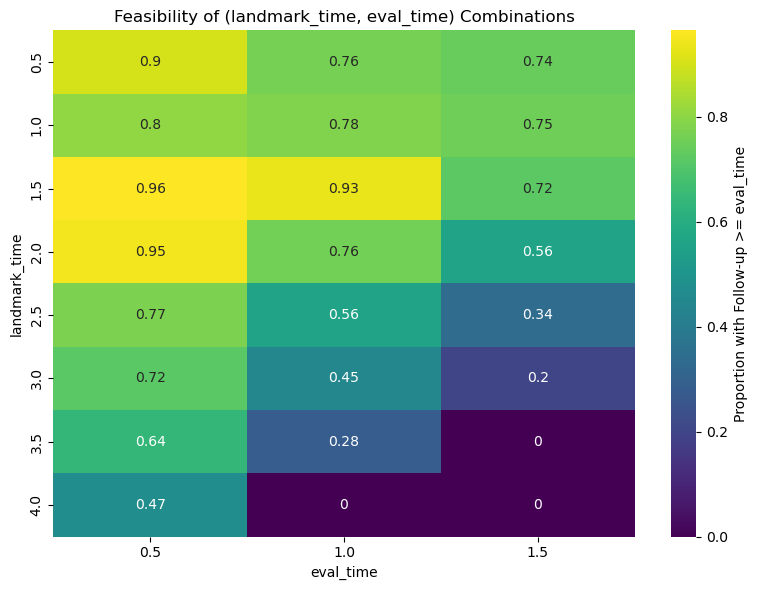

In [84]:
# trying to see which landmarks/eval_times are good
import random
import seaborn as sns
import matplotlib.pyplot as plt

# params
sim_dir = "sim_datasets"  
sample_size = 100      # number of datasets to check                      
landmark_times = np.arange(0.5, 4.5, 0.5)    # landmark timepoints
eval_times = [0.5, 1.0, 1.5]                 # prediction windows after landmark

# samples files
all_filenames = [f for f in os.listdir(sim_dir) if f.endswith(".csv")]
sampled_filenames = random.sample(all_filenames, k=min(sample_size, len(all_filenames)))

# analysis fcn
def check_landmark_eval_feasibility(file_list, sim_dir, landmark_times, eval_times):
    summary = []
    for filename in file_list:
        path = os.path.join(sim_dir, filename)
        for t_lm in landmark_times:
            (X_train, X_test, y_train, y_test), df_snapshot = prepare_landmark_data(df, t_lm)

            for eval_time in eval_times:
                max_time = y_train["time"].max()
                prop_ok = (y_train["time"] >= eval_time).mean()
                n_patients = len(y_train)

                summary.append({
                    "filename": filename,
                    "landmark_time": t_lm,
                    "eval_time": eval_time,
                    "n_patients": n_patients,
                    "prop_with_sufficient_followup": prop_ok,
                    "max_time_from_lm": max_time
                })

    return pd.DataFrame(summary)

summary_df = check_landmark_eval_feasibility(
    file_list=sampled_filenames,
    sim_dir=sim_dir,
    landmark_times=landmark_times,
    eval_times=eval_times
)

pivot_table = summary_df.pivot_table(
    index="landmark_time",
    columns="eval_time",
    values="prop_with_sufficient_followup",
    aggfunc="mean"
)

plt.figure(figsize=(8, 6))
sns.heatmap(pivot_table, annot=True, cmap="viridis", cbar_kws={'label': 'Proportion with Follow-up >= eval_time'})
plt.title("Feasibility of (landmark_time, eval_time) Combinations")
plt.xlabel("eval_time")
plt.ylabel("landmark_time")
plt.tight_layout()
plt.show()


In [92]:
# init 
results = []
skipped = []

landmark_times = [0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5]
eval_time = 1.0

sim_dir = "sim_datasets"

In [88]:
filenames = [f for f in os.listdir(sim_dir) if f.endswith(".csv")]

# Sort them numerically by 'replicate' number using extract_sim_params
filenames = sorted(
    filenames,
    key=lambda f: extract_sim_params(f)["replicate"] if extract_sim_params(f) else float("inf")
)

In [94]:
# main loop
for idx, filename in enumerate(filenames):
    if (idx + 1) % 10 == 0:
        print(f"Processed {idx + 1} files...")

    param_info = extract_sim_params(filename)

    path = os.path.join(sim_dir, filename)
    df = load_simulated_data(path)
    for t_lm in landmark_times:
        try:
            # prep landmarked data
            result = prepare_landmark_data(df, t_lm)
            if not isinstance(result, tuple) or len(result) != 2:
                raise ValueError("prepare_landmark_data did not return expected output")

            (X_train, X_test, y_train, y_test), df_snapshot = result

            max_train_time = y_train["time"].max()
            if eval_time > max_train_time:
                print(f"Skipping t={t_lm} for {filename}: not enough follow-up (max time_from_lm = {max_train_time:.2f})")
                skipped.append({
                    "filename": filename,
                    "landmark_time": t_lm,
                    "eval_time": eval_time,
                    "max_time_from_lm": max_train_time
                })
                continue

            # fit models
            rsf_out = fit_rsf(X_train, X_test, y_train, y_test, eval_time=eval_time)
            gbst_out = fit_gbst(X_train, X_test, y_train, y_test, eval_time=eval_time)

            results.append({
                **param_info,
                "landmark_time": t_lm,
                "rsf_cindex": rsf_out["c_index"],
                "gbst_cindex": gbst_out["c_index"]
                # brier later maybe
            })

        except Exception as e:
            print(f"Failed on file {filename}, t={t_lm}")
            print(f"Exception: {type(e).__name__} — {e}")


Skipping t=4 for rep1_nonlinFALSE_intFALSE_noiseFALSE_extra0.csv: not enough follow-up (max time_from_lm = 0.90)
Skipping t=4.5 for rep1_nonlinFALSE_intFALSE_noiseFALSE_extra0.csv: not enough follow-up (max time_from_lm = 0.47)
Skipping t=4 for rep1_nonlinFALSE_intFALSE_noiseFALSE_extra10.csv: not enough follow-up (max time_from_lm = 0.93)
Skipping t=4.5 for rep1_nonlinFALSE_intFALSE_noiseFALSE_extra10.csv: not enough follow-up (max time_from_lm = 0.41)
Skipping t=4 for rep1_nonlinFALSE_intFALSE_noiseTRUE_extra0.csv: not enough follow-up (max time_from_lm = 0.94)
Skipping t=4.5 for rep1_nonlinFALSE_intFALSE_noiseTRUE_extra0.csv: not enough follow-up (max time_from_lm = 0.44)
Skipping t=4 for rep1_nonlinFALSE_intFALSE_noiseTRUE_extra10.csv: not enough follow-up (max time_from_lm = 0.97)
Skipping t=4.5 for rep1_nonlinFALSE_intFALSE_noiseTRUE_extra10.csv: not enough follow-up (max time_from_lm = 0.47)
Skipping t=4 for rep1_nonlinFALSE_intTRUE_noiseFALSE_extra0.csv: not enough follow-up (m

In [98]:
results_df = pd.DataFrame(results)
print(results_df.head())
print(results_df.describe())

   replicate  nonlinear  interactions  high_noise  n_extra_vars  \
0          1      False         False       False             0   
1          1      False         False       False             0   
2          1      False         False       False             0   
3          1      False         False       False             0   
4          1      False         False       False             0   

   landmark_time  rsf_cindex  gbst_cindex  
0            0.5    0.957670     0.991807  
1            1.0    0.973161     0.993870  
2            1.5    0.984626     0.991979  
3            2.0    0.970190     0.994580  
4            2.5    0.968142     0.993805  
          replicate  n_extra_vars  landmark_time    rsf_cindex   gbst_cindex
count  22305.000000  22305.000000   22305.000000  22305.000000  22305.000000
mean     100.505671      4.999328       1.993634      0.933383      0.971709
std       57.738287      5.000112       0.997365      0.065561      0.066267
min        1.000000      

In [100]:
# summary by landmark time
summary_by_landmark = results_df.groupby("landmark_time")[["rsf_cindex", "gbst_cindex"]].agg(["mean", "std", "count"])
summary_by_landmark.columns = ['_'.join(col) for col in summary_by_landmark.columns]
summary_by_landmark = summary_by_landmark.reset_index()

print(summary_by_landmark)

   landmark_time  rsf_cindex_mean  rsf_cindex_std  rsf_cindex_count  \
0            0.5         0.936030        0.030034              3200   
1            1.0         0.942091        0.027122              3200   
2            1.5         0.948262        0.028464              3200   
3            2.0         0.947763        0.029742              3200   
4            2.5         0.939377        0.045091              3200   
5            3.0         0.929551        0.061575              3199   
6            3.5         0.889311        0.137552              3106   

   gbst_cindex_mean  gbst_cindex_std  gbst_cindex_count  
0          0.991973         0.004221               3200  
1          0.992703         0.003726               3200  
2          0.989036         0.007184               3200  
3          0.986224         0.009979               3200  
4          0.971198         0.027635               3200  
5          0.962186         0.042953               3199  
6          0.906731      

In [ ]:
# plot over landmark time
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(summary_by_landmark["landmark_time"], summary_by_landmark["rsf_cindex_mean"], label="RSF", marker='o')
plt.plot(summary_by_landmark["landmark_time"], summary_by_landmark["gbst_cindex_mean"], label="GBST", marker='s')
plt.fill_between(
    summary_by_landmark["landmark_time"],
    summary_by_landmark["rsf_cindex_mean"] - summary_by_landmark["rsf_cindex_std"],
    summary_by_landmark["rsf_cindex_mean"] + summary_by_landmark["rsf_cindex_std"],
    alpha=0.2
)
plt.fill_between(
    summary_by_landmark["landmark_time"],
    summary_by_landmark["gbst_cindex_mean"] - summary_by_landmark["gbst_cindex_std"],
    summary_by_landmark["gbst_cindex_mean"] + summary_by_landmark["gbst_cindex_std"],
    alpha=0.2
)

plt.title("Mean C-index by Landmark Time")
plt.xlabel("Landmark Time")
plt.ylabel("C-index")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [95]:
# compare vs sim settings
group_summary = results_df.groupby(
    ["nonlinear", "interactions", "high_noise", "n_extra_vars"]
)[["rsf_cindex", "gbst_cindex"]].mean().reset_index()

print(group_summary.sort_values("rsf_cindex", ascending=False))
